# Multi-device Quantum Circuit Cutting

This notepad explores a possible technique for implementing circuit cutting with Pennylane by distributing the various *tapes* derived from the cutting to different quantum devices.

## Code design remark

The idiomatic style of recent Pennylane versions is based on function decorators. However, this approach makes it rather troublesome to extract and individually execute the sub-circuits, which is needed in order to distribute them on different quantum devices.

Therefore, the following code is based on the simple imperative approach described in the docstring of the `cut_circuit` function (`pennylane/qcut/cutcircuit.py`).

In [59]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

## Quantum Devices

The sub-circuits will be executed in the following devices, reused in a round-robin fashion if needed.

In [60]:
from qiskit_aer import AerSimulator, UnitarySimulator

devices = [
    #qml.device("default.qubit", wires=2),
    #qml.device("lightning.qubit", wires=2),
    qml.device("qiskit.aer", wires=2),
    qml.device("qiskit.aer", wires=2, backend=AerSimulator(), method="automatic"),
    qml.device("qiskit.aer", wires=2, backend=UnitarySimulator()),
]

#devices = [
    #qml.device("qiskit.ibmq", wires=2, backend='ibm_brisbane'),
    #qml.device("qiskit.ibmq", wires=2, backend='ibm_kyoto'),
#]

## Circuit definition

The circuit is defined as a simple list of operations. In this example there is **a manual cut**.

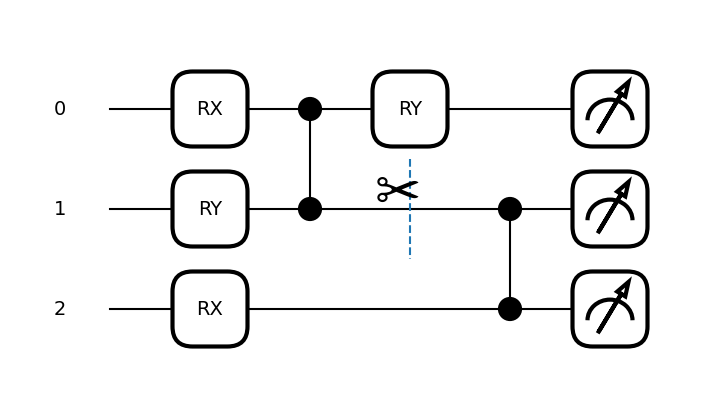

In [61]:
ops = [
    qml.RX(0.531, wires=0),
    qml.RY(0.9, wires=1),
    qml.RX(0.3, wires=2),

    qml.CZ(wires=(0,1)),
    qml.RY(-0.4, wires=0),

    qml.WireCut(wires=1),

    qml.CZ(wires=[1, 2]),
]
measurements = [qml.expval(qml.pauli.string_to_pauli_word("ZZZ"))]
original_tape = qml.tape.QuantumTape(ops, measurements)
qml.drawer.tape_mpl(original_tape)
plt.savefig("pennylane-cutting.pdf", format="pdf", bbox_inches="tight")

## Tape to graph conversion

In order to perform the cut:
  1. the circuit is converted to its graph representation;
  2. the `WireCut` nodes are then replaced with `MeasureNode` and `PrepareNode` pairs;
  3. the graph is decomposed into disconnected components
  4. the disconneted components are converted back to tapes
  5. tape wires are remapped to device wires.

[<AerDevice device (wires=2, shots=1024) at 0x2864184be90>, <AerDevice device (wires=2, shots=1024) at 0x286454ed3d0>, <AerDevice device (wires=2, shots=1024) at 0x286454ee5d0>]


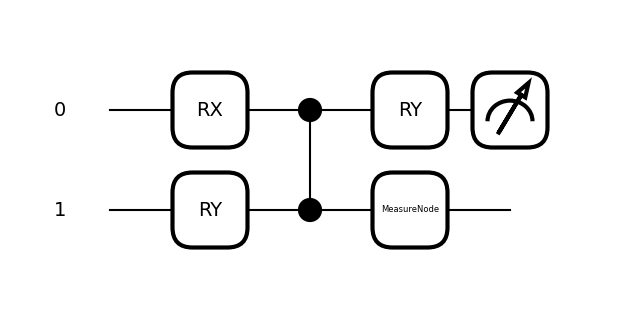

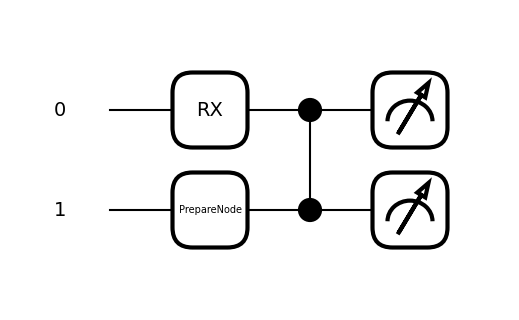

In [62]:
#cut_graph = qml.qcut.find_and_place_cuts(
#    graph = qml.qcut.tape_to_graph(original_tape),
#    cut_strategy = qml.qcut.CutStrategy(max_free_wires=2),
#)

graph = qml.qcut.tape_to_graph(original_tape)
qml.qcut.replace_wire_cut_nodes(graph)
fragments, communication_graph = qml.qcut.fragment_graph(graph)
fragment_tapes = [qml.qcut.graph_to_tape(f) for f in fragments]
print(devices)
fragment_tapes = [qml.map_wires(t, dict(zip(t.wires, devices[0].wires)))[0][0] for t in fragment_tapes]
for i, t in enumerate(fragment_tapes):
    qml.drawer.tape_mpl(t)
    plt.savefig(f"pennylane-subcircuit-{i}.pdf", format="pdf", bbox_inches="tight")

## Sub-circuit expansion

Each circuit fragment is now expanded over the `MeasureNode` and `PrepareNode` configurations and a flat list of tapes is created.

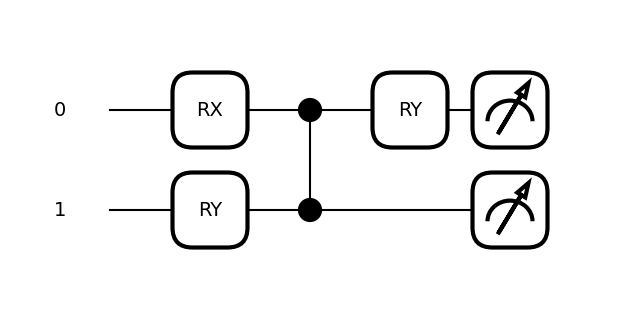

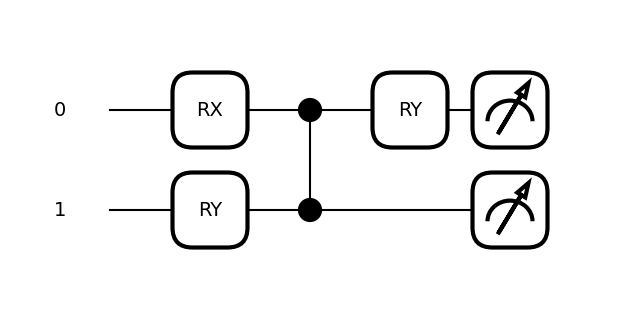

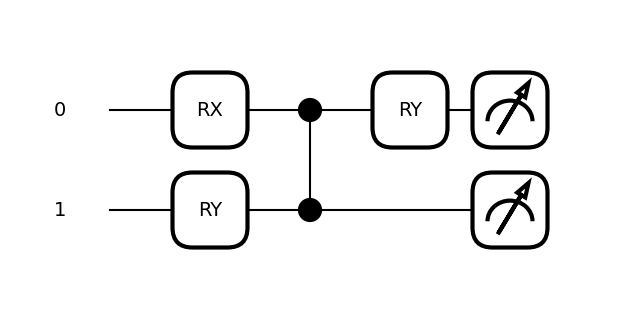

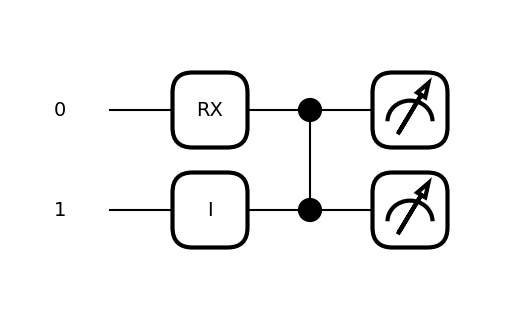

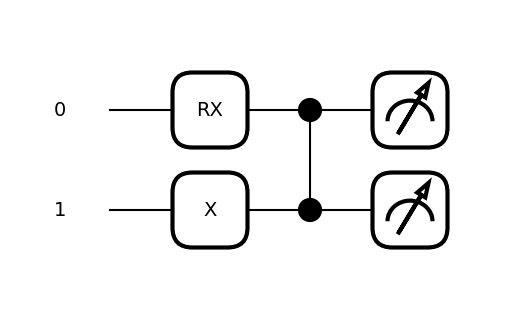

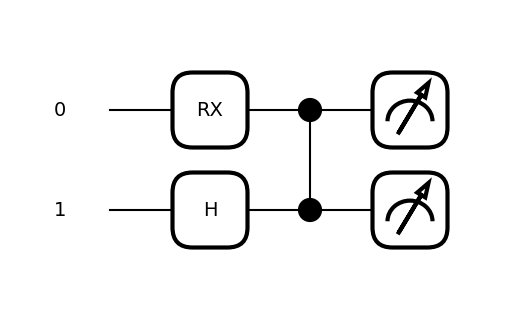

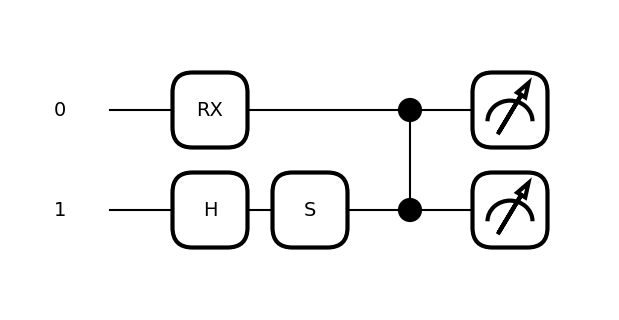

In [63]:
expanded = [qml.qcut.expand_fragment_tape(t) for t in fragment_tapes]
configurations = []
prepare_nodes = []
measure_nodes = []
for t, p, m in expanded:
    configurations.append(t)
    prepare_nodes.append(p)
    measure_nodes.append(m)
sub_tapes = tuple(tape for c in configurations for tape in c)
for i, t in enumerate(sub_tapes):
    qml.drawer.tape_mpl(t)
    plt.savefig(f"pennylane-expanded-subcircuit-{i}.pdf", format="pdf", bbox_inches="tight")

## Execution and error estimation

Finally, each sub-circuit is executed on a specific device and individual results are reassembled by means of a classical post-processing function.

In [64]:
results = []
for i, t in enumerate(sub_tapes):
    dev = devices[i % len(devices)]
    res = qml.execute([t], dev, gradient_fn=None)[0]
    print(f"PARTIAL RES {i}: {res} ({type(res)})")
    results.append(res)

result_with_cut = qml.qcut.qcut_processing_fn(
    results,
    communication_graph,
    prepare_nodes,
    measure_nodes,
)

print("RESULT (with cutting) =", result_with_cut)

PARTIAL RES 0: (array(0.79101562), array(0.47460938)) (<class 'tuple'>)
PARTIAL RES 1: 0.693359375 (<class 'numpy.ndarray'>)
PARTIAL RES 2: 0.154296875 (<class 'numpy.ndarray'>)
PARTIAL RES 3: 0.939453125 (<class 'numpy.ndarray'>)
PARTIAL RES 4: -0.966796875 (<class 'numpy.ndarray'>)
PARTIAL RES 5: 0.017578125 (<class 'numpy.ndarray'>)
PARTIAL RES 6: 0.046875 (<class 'numpy.ndarray'>)
RESULT (with cutting) = 0.4725570678710938


For comparison purposes the following code executes the whole circuit without cutting.

In [65]:
dev = qml.device("lightning.qubit", wires=3)
result_without_cut = qml.execute([original_tape], dev, gradient_fn=None)[0]
print(f"RESULT (without cutting, ideal simulator) = {result_without_cut}")
error = result_without_cut - result_with_cut
error_perc = error * 100 / result_without_cut
print(f"ERROR = {error} ({error_perc}%)")

RESULT (without cutting, ideal simulator) = 0.4716519888211114
ERROR = -0.0009050790499823824 (-0.1918955228503577%)
